# DaKanjiRecognizer - Single Kanji CNN : Training

## Setup

Import the needed libraries.

In [1]:
#std lib
import sys
import os
import random
import math
import random
import multiprocessing as mp
import gc
import time
import datetime

#reading the dataset
from etldr.etl_data_reader import ETLDataReader
from etldr.etl_character_groups import ETLCharacterGroups
from etldr.etl_data_names import ETLDataNames

#data handling
import PIL
from PIL import Image as PImage
from PIL import ImageFilter
import numpy as np

#ML
%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

#creating one hot encodings
from sklearn.preprocessing import LabelBinarizer

#plotting/showing graphics
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

#define a font to show japanese characters in matplotlib figures
import matplotlib.font_manager as fm
font = fm.FontProperties(fname=os.path.join("font", "NotoSerifCJKjp-Regular.otf"), size=20)

Because the data sets are big let's make sure that the GPU is available to speed up training.

In [2]:
print("GPUs Available: ", tf.test.gpu_device_name())

GPUs Available:  /device:GPU:0


If a GPU with native 16 bit float support (ex.: RTX-series) is available, enable support for it here.

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


## Preparing the data

The [ETL Character data set](http://etlcdb.db.aist.go.jp/) which I am using is a data set with multiple sub sets (ETL1 - ETL7, ETL8B, ETL8G, ETL9B and ETL9G). <br/>
After unpacking the data set I renamed all folders and files to have a uniform naming scheme: "ETLX/ETLX_Y". "X" is the number of the subset and Y the part of the subset. Also ETL7S was removed (ETL7L just smaller), the following renaming was also done: <br/>
ETL8B $\rightarrow$ ETL1, ETL8G $\rightarrow$ ETL9, ETL9B $\rightarrow$ ETL10 and ETL9G $\rightarrow$ ETL11.<br/>
This leads to the following data set structure: <br/> 

| name  |   type  |                    content                                              |   res   | Bit depth |    code    | samples perlabel | total samples |
|:-----:|:-------:|:-----------------------------------------------------------------------:|:-------:|:---------:|:----------:|:----------------:|:-------------:|
| ETL1  | M-Type  | Numbers <br/> Roman <br/> Symbols <br/> Katakana                        |  64x63  |     4     | JIS X 0201 |   ~1400          |     141319    |
| ETL2  | K-Type  | Hiragana <br/> Katakana <br/> Kanji <br/> Roman <br/> Symbols           |  60x60  |     6     |    CO59    |     ~24          |      52796    |
| ETL3  | C-Type  | Numeric <br/> Capital Roman <br/> Symbols                               |  72x76  |     4     | JIS X 0201 |     200          |       9600    |
| ETL4  | C-Type  | Hiragana                                                                |  72x76  |     4     | JIS X 0201 |     120          |       6120    |
| ETL5  | C-Type  | Katakana                                                                |  72x76  |     4     | JIS X 0201 |    ~200          |      10608    |
| ETL6  | M-Type  | Katakana <br/> Symbols                                                  |  64x63  |     4     | JIS X 0201 |    1383          |     157662    |
| ETL7  | M-Type  | Hiragana <br/> Symbols                                                  |  64x63  |     4     | JIS X 0201 |     160          |      16800    |
| ETL8  | 8B-Type | Hiragana <br/> Kanji                                                    |  64x63  |     1     | JIS X 0208 |     160          |     157662    |
| ETL9  | 8G-Type | Hiragana <br/> Kanji                                                    | 128x127 |     4     | JIS X 0208 |     200          |     607200    |
| ETL10 | 9B-Type | Hiragana <br/> Kanji                                                    |  64x63  |     1     | JIS X 0208 |     160          |     152960    |
| ETL11 | 9G-Type | Hiragana <br/> Kanji                                                    | 128x127 |     4     | JIS X 0208 |     200          |     607200    |


Because the provided data set is distributed in a proprietary binary data format and therefore a little hard to handle I created a ```ETL_data_reader```-package. This package can be found [here](https://github.com/CaptainDario/ETL_data_reader).
The specific dataformat is C-struct like for types: M, 8B, 8G, 9B, 9G. But the types C and K have a 6-bit code. All codes can be found on the [official website.](http://etlcdb.db.aist.go.jp/file-formats-and-sample-unpacking-code)
I used the [struct module](https://docs.python.org/3/library/struct.html) and the [bitstring module](https://pypi.org/project/bitstring/) to unpack the binary data. <br/>

First an instance of the ```ERL_data_reader``` -class is needed.
The path parameter should lead to the folder in which all parts of the ETL data set can be found.

In [4]:
path = "F:\data_sets\ETL_kanji"
reader = ETLDataReader(path)

Now check that everything is setup correctly by loading samples from the data set and showing one.

In [5]:
sample_img, sample_lable = reader.read_dataset_file(1, ETLDataNames.ETL11, [ETLCharacterGroups.all])

  0%|          | 0/12144 [00:00<?, ?it/s]

Define a convenience function for showing characters and their label.

In [6]:
def show_image(img : np.array, label : str):
    plt.figure(figsize=(2.2, 2.2))
    plt.title(label=label, font=font)
    plt.axis("off")
    plt.imshow(img.astype(np.float64), cmap="gray")

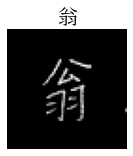

In [7]:
show_image(sample_img[200], sample_lable[200])
# free again
del(sample_img)
del(sample_lable)

Now load all samples which are Kanji characters.

In [8]:
#x, y =  reader.read_dataset_part(ETLDataNames.ETL9, [ETLCharacterGroups.kanji], 16)    # load only a part for testing
x, y = reader.read_dataset_whole([ETLCharacterGroups.kanji], 16)
print(x.shape, y.shape)

  0%|          | 0/127 [00:00<?, ?it/s]

(1520367, 64, 64, 1) (1520367,)


With the loaded data we can take a look at the class distributions.

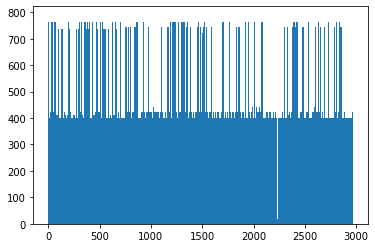

In [20]:
unique, counts = np.unique(y, return_counts=True)
balance = dict(zip(unique, counts))

plt.bar(range(0, len(counts)), counts, width=1.0)
plt.show()

The data will allways be loaded in the same order. Therefore it needs to be shuffled before training.

In [9]:
# because the data is ordered shuffle it
rng_state = np.random.get_state()
np.random.shuffle(x)
np.random.set_state(rng_state)
np.random.shuffle(y)

For the CNN to be able to use the labels, a one-hot-encoding of them is needed.

In [10]:
#one hot encode the labels
lb = LabelBinarizer()
lb.fit(y)
o_y = lb.transform(y)

# free the memory from the original string labels
del(y)

Because the unique classes will be needed for inference later, <br>
create a list of them and save them to file. 

In [11]:
# concat classes-list to string
classes = [i for i in lb.classes_]
s = "".join([i for i in lb.classes_])

# save a list of all labels into a .txt file
with open("../labels.txt", "w+", encoding="utf8") as f:
    f.write(s)
    
# a string formatted as a python list can be easily evaluated 
# therefore lets save this representation too
with open("../labels_python_list.txt", "w+", encoding="utf8") as f:
    f.write(str(classes))

Later we want to access the data from different processes. <br>
To do this the array of the images/labels need to be stored in shared memory.

In [12]:
# store the images in a shared array and free the loaded data
memory_size_x = x.shape[0] * x.shape[1] * x.shape[2] * x.shape[3]
x_shared = mp.RawArray("f", memory_size_x // 2)
x_np = np.frombuffer(x_shared, dtype="float16").reshape(x.shape)
np.copyto(x_np, x)
del(x)

In [13]:
# store the labels in a shared array and free the loaded data
memory_size_y = o_y.shape[0] * o_y.shape[1]
y_shared = mp.RawArray('b', memory_size_y)
y_np = np.frombuffer(y_shared, dtype="b").reshape(o_y.shape)
np.copyto(y_np, o_y)
del(o_y)

Make sure the memory was freeed by running the garbage collector.

In [14]:
gc.collect()

2431

To ensure that the RawArrays are correct, show a random sample and its label.

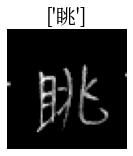

In [15]:
show_image(x_np[200], lb.inverse_transform(np.array([y_np[200]])))

## Defining a thread-safe Datagenerator

**caution: on windows multiprocesing in jupyter is difficult. For actual training use `training.py`** on windows.

Because the data set is too large to fit into memory we will first generate a data generator to create batches on the fly. <br> 
Instantiate a generator for training and testing. <br>
This generator uses multi processing. Multi processing does not work in jupyter notebooks (on windows) when defined in the notebook. Therefore the datagenerator is implemented in `DataGenerator.py`.

In [23]:
import DataGenerator

train_generator = DataGenerator.DataGenerator(len(x_np), 2048, 
                                            80, "training", 
                                            x_shared, y_shared, 
                                            x_np.shape, y_np.shape,
                                            8, True)
test_generator = DataGenerator.DataGenerator(len(y_np), 2048, 
                                            20, "testing", 
                                            x_shared, y_shared, 
                                            x_np.shape, y_np.shape,
                                            8, True)

In [24]:
train_x, train_y = train_generator.__getitem__(10)
test_x, test_y   = test_generator.__getitem__(10)

Lets look at a sample from each generator.

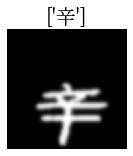

In [25]:
show_image(train_x[23], lb.inverse_transform(np.array([train_y[23]])))

## Defining and training the CNN

In [16]:
def get_model(name : str):
    _model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(input_shape=(64, 64, 1), kernel_size=3, activation='relu', filters=32, name="conv2D_1_2_input"),
        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=32, name="conv2D_1_1"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_1"),

        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=32, name="conv2D_2_1"),
        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=32, name="conv2D_2_2"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_2"),

        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=64, name="conv2D_3_1"),
        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=64, name="conv2D_3_2"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_3"),

        tf.keras.layers.Conv2D(kernel_size=3, activation='relu', filters=128, name="conv2D_4_1"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, name="maxpool_4"),

        tf.keras.layers.Flatten(name="flatten_1"),
        tf.keras.layers.Dropout(0.25, name="dropout_1"),
        
        tf.keras.layers.Dense(2048, name="dense_1"),
        tf.keras.layers.Dropout(0.1, name="dropout_2"),

        tf.keras.layers.Dense(2048, name="dense_2"),
        tf.keras.layers.Dropout(0.25, name="dropout_3"),

        tf.keras.layers.Dense(len(lb.classes_), name="dense_3"),

        #set the dtype to float32 for numerical stability
        tf.keras.layers.Softmax(dtype="float32", name="softmax_1_output") 
    ], name=name)
    
    return _model


f16_model = get_model("DaKanjiRecognizer_f16")
print(f16_model.output_shape)
f16_model.summary()

(None, 2967)
Model: "DaKanjiRecognizer_f16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_1_2_input (Conv2D)    (None, 62, 62, 32)        320       
_________________________________________________________________
conv2D_1_1 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 30, 30, 32)        0         
_________________________________________________________________
conv2D_2_1 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2D_2_2 (Conv2D)          (None, 26, 26, 32)        9248      
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 13, 13, 32)        0         
_________________________________________________________________
conv2D_3_1 (Conv2D)          (No

Set the optimizer, loss function and compile the model

In [17]:
#path where the model should be saved
model_dir = os.path.join(os.path.dirname(os.getcwd()), "model")
print(model_dir)

E:\projects\DaKanjiRecognizerML\CNN_kanji\model


In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-08,)

f16_model.compile(optimizer=opt,
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [19]:
#optionally load stored weights to resume training
f16_model.load_weights(os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-145-0.98.hdf5"))

In [20]:
#checkpoints setup
filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

log_dir = os.path.join(model_dir, "tf", "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard_callback]

Finally train the model on the data set (in case of an Interrupt creates checkpoints).

In [ ]:
#train the model
hist = f16_model.fit(
    x=train_generator,
    epochs=150,
    initial_epoch=0,
    validation_data=test_generator,
    max_queue_size=400,
    callbacks=callbacks_list,
    workers=1
)

## Evaluating the model

After training plot the loss and accuracy for the test and validation sets.

In [ ]:
fig, axs = plt.subplots(2, 1)

#plt.subplots_adjust(right=2.0, top=1.8)

axs[0].plot(hist.history["accuracy"], label="accuracy")
axs[0].plot(hist.history["loss"], label="loss")
axs[0].set_xlabel("epoch", font=font)
axs[0].set_ylabel("", font=font)
axs[0].legend()

axs[1].plot(hist.history["val_accuracy"], label="val_accuracy")
axs[1].plot(hist.history["val_loss"], label="val_loss")
axs[1].set_xlabel("epoch", font=font)
axs[1].set_ylabel("", font=font)

The graphs look good. A training accuracy of ~90% and a validation accuracy of ~95% was reached.<br/>
Let's now make a prediction.

(64, 64, 1)


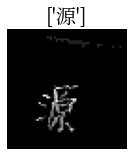

In [39]:
print(x_np[0].shape)

sample = train_x[34]

prediction = f16_model.predict(sample.reshape(1, 64, 64, 1))
t_prediction = lb.inverse_transform(np.array(prediction))
show_image(sample, t_prediction)

## Saving the model

The model is perfoming very well therefore save the trained model as a "*.pb" file.

In [28]:
f16_model.save(os.path.join(model_dir, "tf", "trained_model"))

INFO:tensorflow:Assets written to: E:\projects\DaKanjiRecognizerML\CNN_kanji\model\tf\trained_model\assets


In [29]:
# Create a float32 model with the same weights as the mixed_float16 model, so
# that it loads into TF Lite
tf.keras.mixed_precision.set_global_policy("float32")
f32_model = get_model("DaKanjiRecognizer_f32")
f32_model.set_weights(f16_model.get_weights())
#f32_model.summary()

Finally convert the model to a TF-Light model to be used in other applications ([DaKanjiRecognizer Desktop](https://github.com/CaptainDario/DaKanjiRecognizer-Desktop))

In [30]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(f32_model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open(os.path.join(model_dir, "tflite", "model.tflite"), 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\dario\AppData\Local\Temp\tmpwv47bk1k\assets
